# Trade Under Pressure



## Import packages

In [1936]:
%load_ext autoreload
%autoreload 1
%aimport thesis_utils

import thesis_utils as tu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1937]:
import functools as ft

import matplotlib.pyplot as plt
import numpy as np
import pandas as pa
import seaborn as sns
from loguru import logger

import geopandas as gpd

from sklearn import preprocessing

## Data preprocessing
### Dist CEPII

In [1938]:
# Loading and preprocessing Dist CEPII dataset
dist_df = pa.read_excel("./data/geographic/dist_cepii.xls",
                        index_col=None, header=0,
                        na_values=[".", "nan", "NaN"], verbose=False, decimal=",",
                        dtype={ "contig": bool, "comlang_off": bool,
                                "comlang_ethno": bool, "colony": bool,
                                "smctry": bool }
                        )
dist_df = tu.clean_cepii(dist_df)
logger.info("Hello")

### GSDB V4 Dyadic

In [1939]:
gsdb_df = pa.read_stata("data/sanctions/GSDB_V4_Dyadic.dta")
gsdb_df = tu.clean_gsdb(gsdb_df)

### GDP Data

In [1940]:
gdp_df_raw = pa.read_csv(filepath_or_buffer="data/economic/GDP(currentUSD)_1974-2023.csv", sep=",",
                         na_values=["..", "nan"])
gdp_df = tu.clean_gdp(gdp_df_raw, missing_threshold=0.25)
gdp_df

Missing threshold:  0.25


,ISO3,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,ALB,NaN,NaN,NaN,NaN,NaN,NaN,1.578102e+09,1.808177e+09,1.861163e+09,...,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.537951e+10,1.558511e+10,1.524146e+10,1.803201e+10,1.901724e+10,2.354718e+10
2,DZA,1.320987e+10,1.555790e+10,1.772824e+10,2.097211e+10,2.636449e+10,3.324371e+10,4.234583e+10,4.434859e+10,4.520717e+10,...,2.389427e+11,1.874939e+11,1.807638e+11,1.898809e+11,1.945545e+11,1.934597e+11,1.648734e+11,1.862312e+11,2.256385e+11,2.476262e+11
4,AND,1.865571e+08,2.201126e+08,2.272839e+08,2.539979e+08,3.080203e+08,4.115487e+08,4.463778e+08,3.889833e+08,3.759147e+08,...,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.324648e+09,3.380613e+09,3.785067e+09
5,AGO,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,...,1.359668e+11,9.049642e+10,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.482465e+10
6,ATG,NaN,NaN,NaN,7.749630e+07,8.803333e+07,1.095852e+08,1.324407e+08,1.493778e+08,1.664259e+08,...,1.378830e+09,1.437756e+09,1.489693e+09,1.531152e+09,1.661530e+09,1.725352e+09,1.410796e+09,1.601367e+09,1.867733e+09,2.033085e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,VUT,NaN,NaN,NaN,NaN,NaN,1.192588e+08,1.211855e+08,1.137818e+08,1.145019e+08,...,7.723160e+08,7.308708e+08,7.808896e+08,8.800618e+08,9.147370e+08,9.365263e+08,9.094210e+08,9.503940e+08,1.022219e+09,1.126313e+09
210,VEN,2.610093e+10,2.746465e+10,3.141953e+10,3.621070e+10,3.931628e+10,4.831093e+10,5.911651e+10,6.632744e+10,6.773674e+10,...,4.823593e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,VNM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.334515e+11,2.392583e+11,2.570960e+11,2.813536e+11,3.101065e+11,3.343653e+11,3.466157e+11,3.664748e+11,4.103240e+11,4.297170e+11
215,ZMB,2.910981e+09,2.442672e+09,2.742859e+09,2.515297e+09,2.811032e+09,3.353445e+09,3.884531e+09,4.008126e+09,3.871117e+09,...,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631151e+10,2.330867e+10,1.813776e+10,2.209642e+10,2.916378e+10,2.757796e+10


Check countries that are in CEPII, but not in gdp_df dataset.

In [1941]:
countries_unique_to_cepii = list(set(dist_df["origin"].unique()) - set(gdp_df["ISO3"].unique()))
countries_unique_to_cepii

['POL',
 'GIB',
 'UKR',
 'MDA',
 'AZE',
 'ESH',
 'HRV',
 'GEO',
 'YEM',
 'CZE',
 'BIH',
 'LVA',
 'PRK',
 'TKM',
 'UZB',
 'BLR',
 'MKD',
 'TWN',
 'SVN',
 'AFG',
 'SER',
 'EST',
 'SMR',
 'ERI',
 'SVK',
 'RUS',
 'ARM',
 'ROM',
 'LBN',
 'LTU',
 'TJK',
 'KGZ',
 'KAZ',
 'MOZ']

Check countries that are in gdp_df, but not in CEPII dataset.

In [1942]:
countries_unique_to_gdp_df = list(set(gdp_df["ISO3"].unique()) - set(dist_df["origin"].unique()))
countries_unique_to_gdp_df

['COD']

### UN Comtrade

In [1943]:
import pandas as pd
import os

# Specify the input and output file paths
input_file = "data/trade/Romania_2020_Plus"  # Update with your input file's path
output_file = "data/trade/Romania_2020_Plus.xlsx"  # Desired output Excel file path

# Determine the file extension to decide how to read the input file
_, ext = os.path.splitext(input_file)
ext = ext.lower()

df = None  # Initialize df


def convert(active):
  if active:
    return
  try:
    if ext in ['.csv', '']:
      # Assume the file is tab-delimited (TSV)
      df = pd.read_csv(input_file, sep='\t', low_memory=False)
    elif ext in ['.xls', '.xlsx']:
      df = pd.read_excel(input_file)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")
    print("File read successfully!")
  except Exception as e:
    print(f"Error reading the input file: {e}")

  # Only attempt conversion if the DataFrame was successfully created
  if df is not None:
    try:
      df.to_excel(output_file, index=False)
      print(f"Conversion successful! The Excel file is saved as: {output_file}")
    except Exception as e:
      print(f"Error writing to Excel: {e}")
  else:
    print("Skipping conversion to Excel because the input file could not be read.")


# Read the input file into a DataFrame
convert(True)




## Collect and analyze country labels in all the data sets

### Country codes

In [1944]:
codes_df = pa.read_excel("./data/geographic/country_codes.xls",
                         dtype={
                           "CountryCode": object,
                         })
codes_df = tu.clean_codes(codes_df)

In [1945]:
codes_df_labels = codes_df["ISO3"]

In [1946]:
np.array(codes_df_labels)

array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG',
       'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR',
       'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN',
       'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'ETH', 'EUN', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB',
       'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN',
       'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU',
       'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD',
       'MLI', 'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS',
       'NAM', 'NER',

### DIST CEPII Labels

In [1947]:
dist_labels_origin = dist_df["origin"].unique()
print(len(dist_labels_origin))
dist_labels_origin

194


array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG',
       'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR',
       'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN',
       'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD',
       'GRL', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR',
       'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT',
       'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX',
       'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI',
       'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA',

In [1948]:
dist_labels_dest = dist_df["destination"].unique()
print(len(dist_labels_dest))
dist_labels_dest

194


array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG',
       'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR',
       'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN',
       'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP',
       'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD',
       'GRL', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR',
       'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT',
       'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX',
       'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI',
       'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA',

In [1949]:
# Check if there are any differences
dist_labels_check = np.array(dist_labels_origin == dist_labels_dest)
print("Any false:", np.any(~dist_labels_check))

Any false: False


In [1950]:
# Sanity check
print("Sum of TRUE values: ", sum(dist_labels_check))
print("Lenght of ALL values: ", len(dist_labels_check))

Sum of TRUE values:  194
Lenght of ALL values:  194


In [1951]:
dist_labels = dist_labels_origin

### GSDB Labels

In [1952]:
gsdb_sanctioning_labels = gsdb_df["ISO3"].unique()
gsdb_sanctioned_labels = gsdb_df["sanctioned_state_iso3"].unique()

In [1953]:
print("Number of unique sanctioning: ", len(gsdb_sanctioning_labels))
print("Number of unique sanctioned: ", len(gsdb_sanctioned_labels))

Number of unique sanctioning:  190
Number of unique sanctioned:  175


In [1954]:
unique_to_sanctioning = list(set(gsdb_sanctioning_labels) - set(gsdb_sanctioned_labels))
print("Unique to SANCTIONING:", unique_to_sanctioning)

unique_to_sanctioned = list(set(gsdb_sanctioned_labels) - set(gsdb_sanctioning_labels))
print("Unique to SANCTIONED: ", unique_to_sanctioned)

Unique to SANCTIONING: ['VUT', 'PNG', 'BTN', 'TUV', 'SWZ', 'VCT', 'BHS', 'SLB', 'PLW', 'KIR', 'BRN', 'FSM', 'KNA', 'ESH', 'TON', 'STP']
Unique to SANCTIONED:  ['GIB']


In [1955]:
gsdb_labels = np.union1d(gsdb_sanctioned_labels, gsdb_sanctioning_labels)
print("Total numbers of GSDB labels: ", len(gsdb_labels))

Total numbers of GSDB labels:  191


### gdp_df Labels

In [1956]:
gdp_df_labels = gdp_df["ISO3"].unique()
gdp_df_labels

array(['ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ABW', 'AUS', 'AUT',
       'BHS', 'BHR', 'BGD', 'BRB', 'BEL', 'BLZ', 'BEN', 'BTN', 'BOL',
       'BWA', 'BRA', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR',
       'CAN', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COD', 'CRI',
       'CIV', 'CUB', 'CYP', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY',
       'SLV', 'GNQ', 'SWZ', 'ETH', 'FRO', 'FJI', 'FIN', 'FRA', 'GAB',
       'GMB', 'DEU', 'GHA', 'GRC', 'GRL', 'GRD', 'GTM', 'GIN', 'GNB',
       'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN',
       'IRQ', 'IRL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KEN', 'KIR',
       'KOR', 'KWT', 'LAO', 'LSO', 'LBR', 'LBY', 'LUX', 'MDG', 'MWI',
       'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MRT', 'MUS', 'MEX', 'FSM',
       'MNG', 'MAR', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NZL', 'NIC',
       'NER', 'NGA', 'NOR', 'OMN', 'PAK', 'PLW', 'PAN', 'PNG', 'PRY',
       'PER', 'PHL', 'PRT', 'PRI', 'QAT', 'RWA', 'WSM', 'STP', 'SAU',
       'SEN', 'SYC',

### Matching

In [1957]:
print("Number of DIST CEPII labels: ", len(dist_labels))
print("Number of GSDB labels: ", len(gsdb_labels))
print("Number of gdp_df labels: ", len(gdp_df_labels))
print("Number of country codes: ", len(codes_df_labels))

label_arrays = [dist_labels, gsdb_labels, gdp_df_labels, codes_df_labels]

intersection_labels = ft.reduce(np.intersect1d, label_arrays)

print("Total number of intersect labels: ", len(intersection_labels))

Number of DIST CEPII labels:  194
Number of GSDB labels:  191
Number of gdp_df labels:  161
Number of country codes:  197
Total number of intersect labels:  156


In [1958]:
# Intersection of each set with each other
inter_dist_gsdb = np.intersect1d(gsdb_labels, dist_labels)
print("Intersect DIST CEPII and GSDB labels: ", len(inter_dist_gsdb))
list(set(gsdb_labels) - set(inter_dist_gsdb))

Intersect DIST CEPII and GSDB labels:  190


['COD']

In [1959]:
list(set(dist_labels) - set(intersection_labels))

['POL',
 'GIB',
 'GRL',
 'UKR',
 'MDA',
 'AZE',
 'ESH',
 'HRV',
 'GEO',
 'YEM',
 'CZE',
 'BIH',
 'LVA',
 'ABW',
 'PRK',
 'TKM',
 'UZB',
 'BLR',
 'MKD',
 'TWN',
 'SVN',
 'AFG',
 'SER',
 'EST',
 'SMR',
 'ERI',
 'SVK',
 'PRI',
 'FRO',
 'RUS',
 'ARM',
 'ROM',
 'LBN',
 'LTU',
 'TJK',
 'KGZ',
 'KAZ',
 'MOZ']

In [1960]:
list(set(gsdb_labels) - set(intersection_labels))

/opt/homebrew/Caskroom/miniconda/base/envs/thesis_env/lib/python3.13/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


['POL',
 'GIB',
 'UKR',
 'MDA',
 'AZE',
 'ESH',
 'COD',
 'HRV',
 'GEO',
 'YEM',
 'CZE',
 'BIH',
 'LVA',
 'PRK',
 'TKM',
 'UZB',
 'BLR',
 'MKD',
 'TWN',
 'SVN',
 'AFG',
 'SER',
 'EST',
 'SMR',
 'ERI',
 'SVK',
 'RUS',
 'ARM',
 'ROM',
 'LBN',
 'LTU',
 'TJK',
 'KGZ',
 'KAZ',
 'MOZ']

In [1961]:
list(set(gdp_df_labels) - set(intersection_labels))

['GRL', 'ABW', 'PRI', 'FRO', 'COD']

In [1962]:
list(set(codes_df_labels) - set(intersection_labels))

['POL',
 'GIB',
 'GRL',
 'UKR',
 'MDA',
 'AZE',
 'ESH',
 'HRV',
 'GEO',
 'YEM',
 'CZE',
 'BIH',
 'LVA',
 'ABW',
 'PRK',
 'TKM',
 'WLD',
 'UZB',
 'BLR',
 'MKD',
 'TWN',
 'SVN',
 'AFG',
 'SER',
 'EST',
 'SMR',
 'ERI',
 'SVK',
 'EUN',
 'PRI',
 'FRO',
 'YUG',
 'RUS',
 'ARM',
 'ROM',
 'LBN',
 'LTU',
 'TJK',
 'KGZ',
 'KAZ',
 'MOZ']

## Combine Data Sets
Merge the existing data sets into combined data sets for data exploration

In [1963]:
# First combine country codes and gdp_df
codes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 274
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ISO3          197 non-null    object
 1   UNDS          197 non-null    object
 2   Country Name  197 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


In [1964]:
# Inner join gdp_df and Country Names
gdp_df_countries = pa.merge(
  gdp_df[gdp_df["ISO3"].isin(intersection_labels)],
  codes_df[codes_df["ISO3"].isin(intersection_labels)]
  , on="ISO3", how="inner", validate="m:m")
gdp_df_countries.info()
list(set(gdp_df_countries["ISO3"]) - set(intersection_labels))
len(intersection_labels)
len(gdp_df_countries["ISO3"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 53 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ISO3          156 non-null    object 
 1   1974          137 non-null    float64
 2   1975          140 non-null    float64
 3   1976          140 non-null    float64
 4   1977          143 non-null    float64
 5   1978          142 non-null    float64
 6   1979          143 non-null    float64
 7   1980          153 non-null    float64
 8   1981          153 non-null    float64
 9   1982          153 non-null    float64
 10  1983          153 non-null    float64
 11  1984          154 non-null    float64
 12  1985          156 non-null    float64
 13  1986          155 non-null    float64
 14  1987          156 non-null    float64
 15  1988          156 non-null    float64
 16  1989          156 non-null    float64
 17  1990          156 non-null    float64
 18  1991          156 non-null    

156

## Data Visualization

In [1965]:
sns.set_theme()
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [1966]:
gdp_df_sorted = gdp_df_countries.sort_values(by=["2023"], ascending=False)
gdp_df_sorted = gdp_df_sorted[["Country Name", "2023"]]

In [1967]:
gdp_df_sorted

,Country Name,2023
149,United States,2.772071e+13
30,China,1.779478e+13
52,Germany,4.525704e+12
73,Japan,4.204495e+12
65,India,3.567552e+12
...,...,...
15,Bhutan,NaN
35,Cuba,NaN
137,Syrian Arab Republic,NaN
141,Tonga,NaN


In [1968]:
gdp_df_year_values = gdp_df_countries[gdp_df_countries.columns.difference(["ISO3", "Country Name", "UNDS"])]
gdp_df_logs = np.log(gdp_df_year_values)
gdp_df_scaled = gdp_df_year_values.apply(
  lambda col: preprocessing.MinMaxScaler().fit_transform(col.values.reshape(-1, 1)).flatten()
)
gdp_df_scaled

,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,NaN,NaN,NaN,NaN,NaN,NaN,0.000551,0.000562,0.000555,0.000517,...,0.000749,0.000620,0.000629,0.000662,0.000742,0.000721,0.000711,0.000759,0.000729,0.000847
1,0.008546,0.009231,0.009461,0.010072,0.011210,0.012651,0.014819,0.013827,0.013519,0.013428,...,0.013568,0.010246,0.009610,0.009680,0.009416,0.008979,0.007719,0.007862,0.008674,0.008931
2,0.000118,0.000128,0.000119,0.000120,0.000129,0.000155,0.000155,0.000120,0.000111,0.000089,...,0.000184,0.000150,0.000152,0.000151,0.000153,0.000144,0.000133,0.000138,0.000128,0.000134
3,NaN,NaN,NaN,NaN,NaN,NaN,0.002074,0.001729,0.001659,0.001591,...,0.007720,0.004945,0.002804,0.003755,0.003844,0.003289,0.002269,0.002806,0.004012,0.003058
4,NaN,NaN,NaN,0.000035,0.000036,0.000040,0.000045,0.000045,0.000049,0.000050,...,0.000076,0.000077,0.000077,0.000076,0.000078,0.000078,0.000064,0.000065,0.000070,0.000071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,NaN,NaN,NaN,NaN,NaN,0.000044,0.000041,0.000034,0.000033,0.000031,...,0.000042,0.000038,0.000039,0.000043,0.000042,0.000041,0.000040,0.000038,0.000037,0.000038
152,0.016889,0.016298,0.016769,0.017392,0.016717,0.018386,0.020688,0.020680,0.020256,0.018589,...,0.027392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013256,0.013076,0.013670,0.014344,0.015010,0.015521,0.016229,0.015473,0.015775,0.015499
154,0.001881,0.001447,0.001462,0.001206,0.001194,0.001275,0.001358,0.001248,0.001156,0.000913,...,0.001539,0.001160,0.001112,0.001317,0.001271,0.001080,0.000847,0.000931,0.001119,0.000993


<Axes: xlabel='2023', ylabel='Count'>

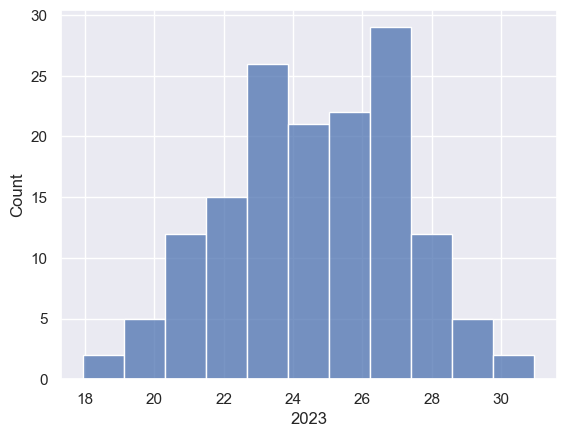

In [1969]:
sns.histplot(data=gdp_df_logs, x="2023")

<Axes: xlabel='2023'>

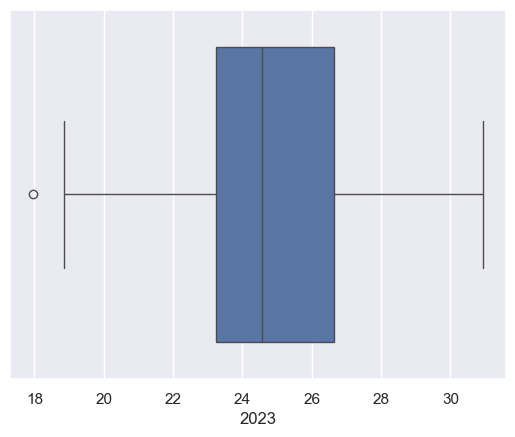

In [1970]:
sns.boxplot(data=gdp_df_logs, x="2023")

In [1971]:
gdp_df_operation = gdp_df_logs
gdp_df_max = gdp_df_operation.max()
gdp_df_min = gdp_df_operation.min()
gdp_df_mean = gdp_df_operation.mean()
gdp_df_missing = gdp_df_operation.isna().sum()
gdp_df_stats = {
  "Year": gdp_df_logs.columns,
  "Max": gdp_df_max.values,
  "Q.75": gdp_df_operation.quantile(q=0.75).values,
  "Mean": gdp_df_mean.values,
  "Q.25": gdp_df_operation.quantile(q=0.25).values,
  "Min": gdp_df_min.values,
  # "Missing": gdp_df_missing.values,
}
gdp_df_stats = pa.DataFrame(data=gdp_df_stats)
gdp_df_stats = gdp_df_stats.sort_values("Year").reset_index(drop=True)
gdp_df_stats["Year"] = gdp_df_stats["Year"].astype(int)

In [1972]:
long_stats = pd.melt(gdp_df_stats, id_vars="Year",
                     var_name="Measure", value_name="Value")
long_stats

,Year,Measure,Value
0,1974,Max,28.066202
1,1975,Max,28.152730
2,1976,Max,28.258782
3,1977,Max,28.364267
4,1978,Max,28.486117
...,...,...,...
245,2019,Min,17.806773
246,2020,Min,17.761869
247,2021,Min,17.913123
248,2022,Min,17.894166


<Axes: xlabel='Value', ylabel='Count'>

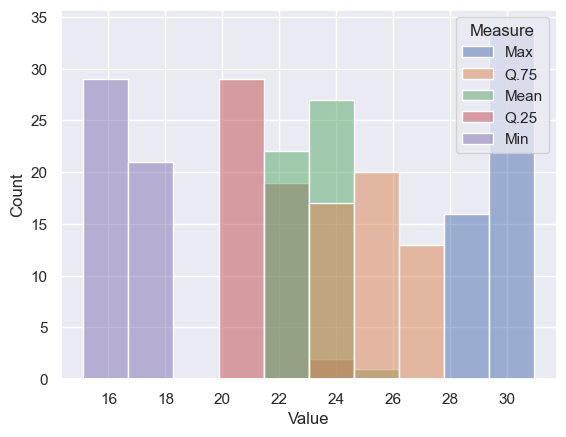

In [1973]:
sns.histplot(data=long_stats, x="Value", hue="Measure")

In [1974]:
def calculate_yearly_change(column_name):
  previous = gdp_df_stats[column_name].shift(1)
  current = gdp_df_stats[column_name]

  change_percent = ((current[1:].values - previous[1:].values) / current[1:].values) * 100
  change_percent = pd.Series(change_percent).round(5)
  return change_percent


# Compute change from previous year (1975 has 1974 as "previous year")
yearly_change_percentage = pd.DataFrame({
  "Year": gdp_df_stats["Year"][1:].values,
  "%-Change-Max": calculate_yearly_change("Max"),
  "%-Change-Min": calculate_yearly_change("Min"),
  "%-Change-Mean": calculate_yearly_change("Mean"),
  # "%-Change-Q.25": calculate_yearly_change("Q.25"),
  # "%-Change-Q.75": calculate_yearly_change("Q.75"),
})

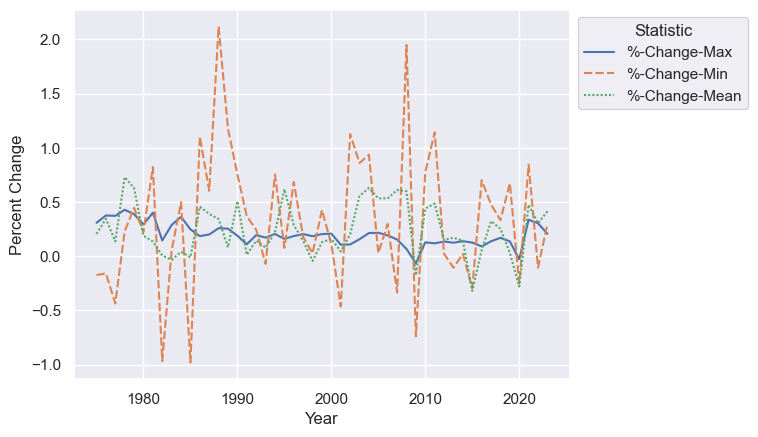

In [1975]:
long_yearly = pd.melt(yearly_change_percentage, id_vars="Year",
                      var_name="Statistic", value_name="Percent Change")

line_plot = sns.lineplot(
  data=long_yearly, x="Year", y="Percent Change", hue="Statistic", style="Statistic"
)

sns.move_legend(
  line_plot,
  "upper left",
  bbox_to_anchor=(1, 1)
)

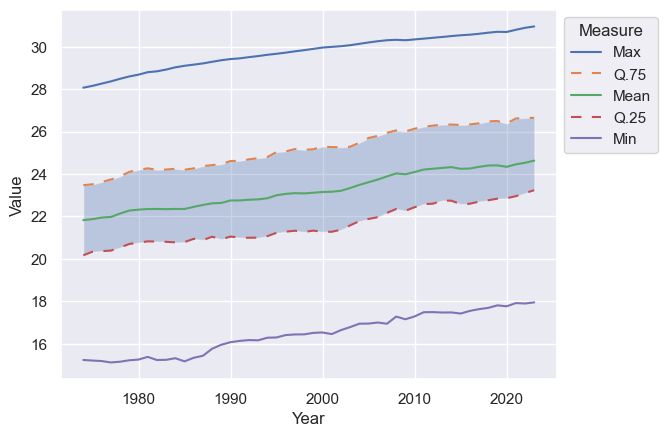

In [1976]:
custom_dashes = {
  'Mean': '',
  'Q.75': (5, 5),
  'Q.25': (5, 5),
  'Max': '',
  'Min': '',
}

gdp_df_plt = sns.lineplot(
  data=long_stats,
  x="Year",
  y="Value",
  hue="Measure",
  style="Measure",
  dashes=custom_dashes
)

sns.move_legend(
  gdp_df_plt,
  "upper left",
  bbox_to_anchor=(1, 1)
)

mean_df = long_stats[long_stats["Measure"] == "Mean"]
q25_df = long_stats[long_stats["Measure"] == "Q.25"]
q75_df = long_stats[long_stats["Measure"] == "Q.75"]

plt.fill_between(
  x=mean_df["Year"],
  y1=q25_df["Value"],
  y2=q75_df["Value"],
  alpha=0.3
)

## Analyse Sanctions

In [1977]:
gsdb_labels = np.union1d(gsdb_sanctioned_labels, gsdb_sanctioning_labels)
print("Total numbers of GSDB labels: ", len(gsdb_labels))

Total numbers of GSDB labels:  191


In [1978]:
gsdb_countries = pa.merge(
  gsdb_df[gsdb_df["ISO3"].isin(intersection_labels)],
  codes_df[codes_df["ISO3"].isin(intersection_labels)]
  , on="ISO3", how="inner", validate="m:1")

In [1979]:
SHAPEFILE = "data/countries/ne_10m_admin_0_countries.shp"
geo_df = gpd.read_file(SHAPEFILE)[["ADM0_A3", "geometry", "ADMIN"]]
geo_df = tu.clean_geopa(geo_df, intersection_labels)

In [1980]:
counts = gsdb_countries["ISO3"].value_counts()

In [1981]:
merged_df = pd.merge(geo_df, counts, on="ISO3", how="inner", validate="m:1")
merged_df.fillna(0)

,ISO3,geometry,ADMIN,count
0,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",Indonesia,570
1,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",Malaysia,592
2,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",Chile,640
3,BOL,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",Bolivia,640
4,PER,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",Peru,646
...,...,...,...,...
151,NRU,"POLYGON ((166.93881 -0.49041, 166.95558 -0.497...",Nauru,393
152,FSM,"MULTIPOLYGON (((163.02605 5.34089, 163.03045 5...",Federated States of Micronesia,445
153,VUT,"MULTIPOLYGON (((169.84034 -20.1408, 169.86052 ...",Vanuatu,498
154,PLW,"MULTIPOLYGON (((134.27149 7.07453, 134.27931 7...",Palau,411


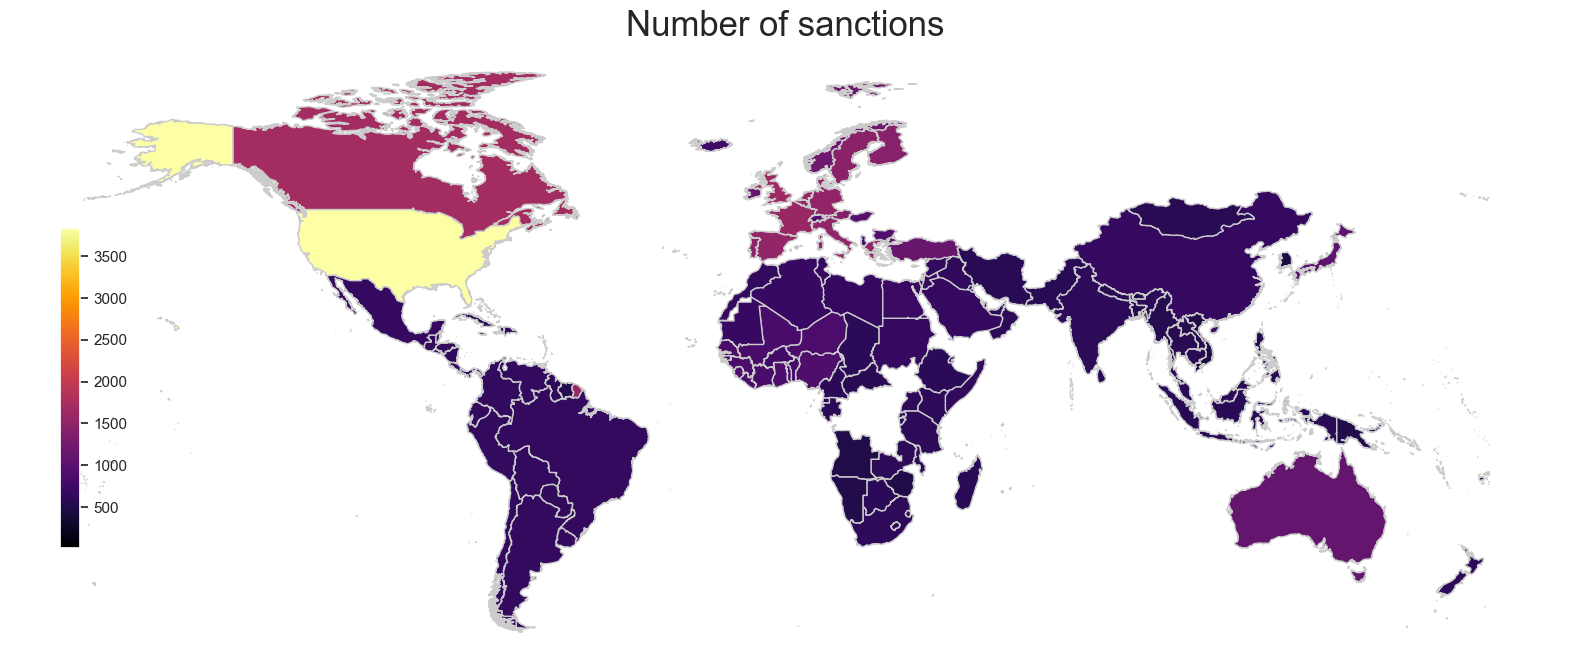

In [1982]:
title = 'Number of sanctions'

vmin = merged_df["count"].min()
vmax = merged_df["count"].max()
cmap = 'inferno'

fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
merged_df.plot(column="count", ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
# Add a title
ax.set_title(title, fontdict={ 'fontsize': '25', 'fontweight': '3' })

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

In [1983]:
intersection_labels

array(['AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ATG', 'AUS', 'AUT', 'BDI',
       'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BLZ', 'BOL',
       'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL',
       'CHN', 'CIV', 'CMR', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP',
       'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'ETH', 'FIN', 'FJI', 'FRA', 'FSM', 'GAB', 'GBR', 'GHA', 'GIN',
       'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GTM', 'GUY', 'HKG', 'HND',
       'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JOR', 'JPN', 'KEN', 'KHM', 'KIR', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LUX', 'MAR',
       'MDG', 'MDV', 'MEX', 'MHL', 'MLI', 'MLT', 'MMR', 'MNG', 'MRT',
       'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR',
       'NPL', 'NRU', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW',
       'PNG', 'PRT', 'PRY', 'QAT', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP',
       'SLB', 'SLE',

In [1984]:
# merged_df.explore()

## Graphs number of countries

In [1985]:
def gdp_threshold_test(data, reduced_labels, start, end, size):
  gdp_copy = data.copy()
  unique_labels = pd.DataFrame()
  for threshold in np.linspace(start, end, size):
    # TODO: Log with DEBUG
    # print("Threshold: ", threshold)
    gdp_clear = tu.clean_gdp(gdp_copy, missing_threshold=threshold)
    intersect_array = np.intersect1d(reduced_labels, gdp_clear["ISO3"].unique())
    add_row = pd.DataFrame(
      [{ "Threshold": threshold, "Count": gdp_clear["ISO3"].nunique(), "Set": "GDP" }])
    unique_labels = pa.concat([unique_labels, add_row])
    add_row = pd.DataFrame(
      [{ "Threshold": threshold, "Count": len(reduced_labels), "Set": "Reduced" }])
    unique_labels = pa.concat([unique_labels, add_row])
    add_row = pd.DataFrame(
      [{ "Threshold": threshold, "Count": len(intersect_array), "Set": "Intersect" }])
    unique_labels = pa.concat([unique_labels, add_row])

  return unique_labels


In [1986]:
# gdp_df
# gsdb_df
# dist_df
# codes_df

intersect_df = pd.DataFrame(
  data={
    "Dataset": ["GSDB", "GDP", "CEPII", "Codes", "Intersect", "Excluded", "Loss"],
    "Countries": [len(gsdb_labels), len(gdp_df_labels), len(dist_labels), len(codes_df_labels),
                  len(intersection_labels), len(tu.Constants.EXCLUDED_COUNTRY_CODES),
                  len(codes_df_labels) - len(intersection_labels) + len(tu.Constants.EXCLUDED_COUNTRY_CODES)],
  }
)
intersect_df = intersect_df.sort_values(by="Countries", ascending=False)

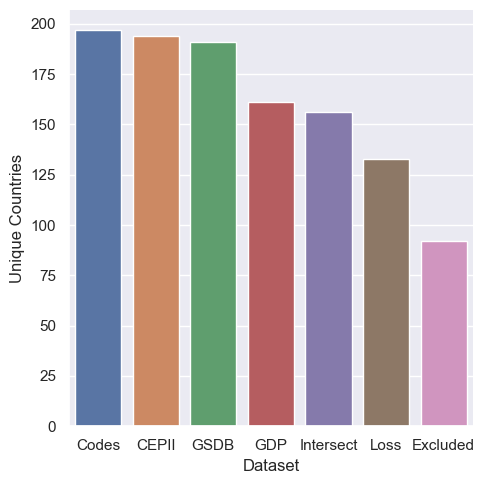

In [1987]:
ax = sns.catplot(data=intersect_df, x="Dataset", y="Countries", hue="Dataset", kind="bar")
ax.set(ylabel="Unique Countries")

In [1988]:
print("Number of unique labels: ", len(intersection_labels))

Number of unique labels:  156


In [1989]:
dist_df.isna().sum()

origin           0
destination      0
contig           0
comlang_off      0
comlang_ethno    0
colony           0
smctry           0
dist             0
distcap          0
distw            0
distwces         0
dtype: int64

In [1990]:
gsdb_df.isna().sum()

case_id                  0
ISO3                     0
sanctioning_state        0
sanctioned_state_iso3    0
sanctioned_state         0
year                     0
arms                     0
military                 0
trade                    0
descr_trade              0
financial                0
travel                   0
other                    0
target_mult              0
sender_mult              0
objective                0
success                  0
dtype: int64

In [1991]:
gdp_df.isna().sum().any()

np.True_

In [2008]:
threshold_test = gdp_threshold_test(gdp_df_raw, start=0.0, end=1.0, size=5, reduced_labels=intersection_labels)

Threshold:  0.0
Missing threshold:  0.0
Threshold:  0.25
Missing threshold:  0.25
Threshold:  0.5
Missing threshold:  0.5
Threshold:  0.75
Missing threshold:  0.75
Threshold:  1.0
Missing threshold:  1.0


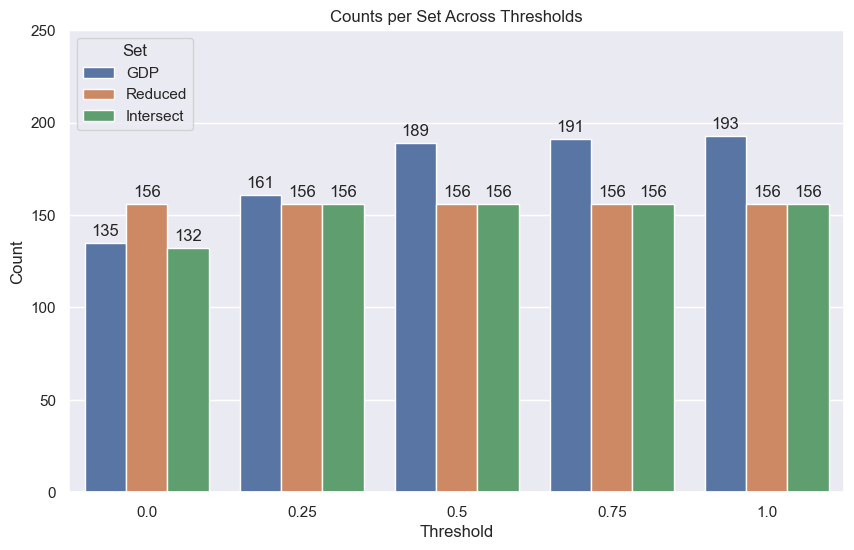

In [2007]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
  data=threshold_test,
  x='Threshold',
  y='Count',
  hue='Set'
)

bar_plot.set_ylim(0, 250)

# Customize the plot with titles and labels
bar_plot.set_title('Counts per Set Across Thresholds')
bar_plot.set_xlabel('Threshold')
bar_plot.set_ylabel('Count')

for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
# Show the plot
plt.show()

---







# --- ENDE GELÄNDE ---